## Aim
Many businesses are very seasonal, and some of them make money during holidays like Super Bowl, Labor Day, Thanksgiving, and Christmas. In addition, they use sales promotions to increase the demand for or visibility of a product or service for several weeks during the year.  

In this post, we are going to analyze the historical data using time series analysis techniques, with promotion effect.  

The data we are going to use is a weekly sales and price data for 9 stores and 3 products. At the end, we are going to forecast the sales for next 50 weeks for one of the three products at one of the stores.  


## Data
- Store: the store code. We have 9 stores in total.
- Product: the product code. We have 3 products in total.
- Is_Holiday: an indicator for whether that week contains holiday: 0 = no, 1 = yes.
- Base Price: base or everyday price without discount.
- Price: Actual price for each week. They are either promotion prices when promotion is going on or everyday prices otherwise.
- Weekly_Units_Sold: Weekly units sold.  

## Ref
- [Plotly Express in Python](https://plot.ly/python/plotly-express/) is a terse, consistent, high-level API for rapid data exploration and figure generation.
- [Prophet](https://facebook.github.io/prophet/) is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
- [statsmodels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator.  
- [Empirical cumulative distribution function (CDF)](https://www.r-bloggers.com/exploratory-data-analysis-conceptual-foundations-of-empirical-cumulative-distribution-functions/) is a non-parametric estimator of the underlying CDF of a random variable.  
- [seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.  


## 0. Import Necessary Packages

In [60]:
import plotly.express as px 
import pandas as pd
import numpy as np
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Import the Dataset

In [29]:
df = pd.read_csv('data/Sales_Product_Price_by_Store.csv', index_col=False, delimiter=',', encoding='utf-8')

## 2. Preview the Dataset

In [30]:
# Display the dimensions of the dataset.
rows = df.shape[0]
columns = df.shape[1]
feature_set = df.columns.values
print('Total Number of Features: ', columns)
print('Total Number of Instances: ', rows)
print('Feature Set includes: ', feature_set) 

Total Number of Features:  7
Total Number of Instances:  3861
Feature Set includes:  ['Store' 'Product' 'Date' 'Is_Holiday' 'Base Price' 'Price'
 'Weekly_Units_Sold']


In [31]:
# Preview the first 10 instances.
df.head(10)

,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,1,1,2/5/2010,False,9.99,7.99,245
1,1,1,2/12/2010,True,9.99,7.99,453
2,1,1,2/19/2010,False,9.99,7.99,409
3,1,1,2/26/2010,False,9.99,7.99,191
4,1,1,3/5/2010,False,9.99,9.99,145
5,1,1,3/12/2010,False,9.99,9.99,140
6,1,1,3/19/2010,False,9.99,9.99,147
7,1,1,3/26/2010,False,9.99,9.99,175
8,1,1,4/2/2010,False,9.99,9.99,382
9,1,1,4/9/2010,False,9.99,9.99,287


In [32]:
# Display the dimensions and data type of the train data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 7 columns):
Store                3861 non-null int64
Product              3861 non-null int64
Date                 3861 non-null object
Is_Holiday           3861 non-null bool
Base Price           3861 non-null float64
Price                3861 non-null float64
Weekly_Units_Sold    3861 non-null int64
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 184.8+ KB


In [33]:
# Return the statistics for all numeric variables.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,3861.0,5.111111,2.767003,1.00,3.00,5.00,7.00,10.00
Product,3861.0,2.000000,0.816602,1.00,1.00,2.00,3.00,3.00
Base Price,3861.0,12.554103,6.079043,5.99,6.99,10.99,19.99,21.99
Price,3861.0,11.766084,5.976196,4.01,5.99,10.00,19.99,21.99
Weekly_Units_Sold,3861.0,215.952603,236.273397,13.00,69.00,130.00,278.00,2557.00


In [34]:
# Data preprocessing and add new feature like weekly sales amount in dollars, year, month, day, week of year.
df['Date'] = pd.to_datetime(df['Date']) # Convert 'object' into 'datetime'
df['weekly_sales'] = df['Price']*df['Weekly_Units_Sold'] # Calculate weekly sales
df.set_index('Date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.weekofyear
df.head(10)

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales,year,month,day,week_of_year
Date,,,,,,,,,,,
2010-02-05,1,1,False,9.99,7.99,245,1957.55,2010,2,5,5
2010-02-12,1,1,True,9.99,7.99,453,3619.47,2010,2,12,6
2010-02-19,1,1,False,9.99,7.99,409,3267.91,2010,2,19,7
2010-02-26,1,1,False,9.99,7.99,191,1526.09,2010,2,26,8
2010-03-05,1,1,False,9.99,9.99,145,1448.55,2010,3,5,9
2010-03-12,1,1,False,9.99,9.99,140,1398.60,2010,3,12,10
2010-03-19,1,1,False,9.99,9.99,147,1468.53,2010,3,19,11
2010-03-26,1,1,False,9.99,9.99,175,1748.25,2010,3,26,12
2010-04-02,1,1,False,9.99,9.99,382,3816.18,2010,4,2,13


## 3. Exploratory Data Analysis (EDA)

Text(0.5, 0, 'Weekly sales')

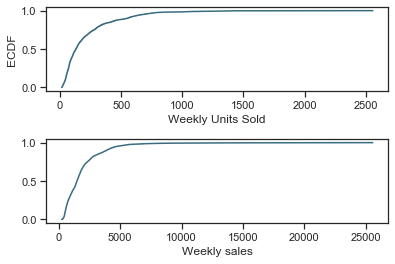

In [35]:
sns.set(style = "ticks")
c = '#386B7F' 

figure, axes = plt.subplots(nrows=2, ncols=2)
figure.tight_layout(pad=2.0)
plt.subplot(211)
cdf = ECDF(df['Weekly_Units_Sold'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Weekly Units Sold') 
plt.ylabel('ECDF')

plt.subplot(212)
cdf = ECDF(df['weekly_sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Weekly sales')

- Although in the best week, a store sold more than 2500 units, about 80% of the time, weekly units sold did not exceed 500.
- Although the highest weekly sales exceeded 25K dollars, over 90% of the data had weekly sales less than 5K dollars.

In [36]:
# Statistics for weekly-sales in each store.
df.groupby(['Store'])['weekly_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Store,,,,,,,,
1,429.0,1789.414172,900.074226,769.65,1208.90,1659.17,1957.20,6816.59
2,429.0,2469.447413,1328.162884,1143.48,1579.21,2215.08,2756.55,9110.00
3,429.0,670.924009,366.816321,229.77,459.77,619.69,730.78,2650.00
4,429.0,3078.462145,1746.147872,1099.45,1818.18,2626.61,3837.51,13753.12
5,429.0,588.922984,242.628977,285.87,461.23,519.74,613.53,2264.97
6,429.0,2066.705082,1163.284768,890.19,1418.58,1758.40,2156.40,7936.03
7,429.0,955.115058,489.084883,389.61,649.35,857.61,1041.51,3270.00
8,429.0,1352.094056,811.326288,516.53,846.23,1275.87,1491.51,6656.67
10,429.0,4093.407249,3130.087191,1483.65,2462.88,3707.81,4510.47,25570.00


In [37]:
# Sum for weekly-unit-sold in each store.
df.groupby('Store')['Weekly_Units_Sold'].sum()

Store
1      86699
2     121465
3      31689
4     158718
5      27300
6      97698
7      44027
8      65273
10    200924
Name: Weekly_Units_Sold, dtype: int64

- It is easy to see that Store 10 has the highest average weekly sales among all 9 stores, also Store 10 has the most total weekly units sold.

- And Store 5 has the lowest average weekly sales.

- Apparently, Store 10 is the most selling and crowded one.

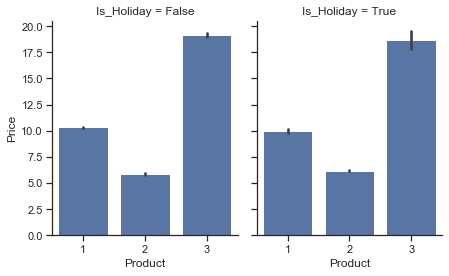

In [41]:
# Plot a 1*2 grid of association between 'Product' and 'Price' under 'Is_Holiday'.
g = sns.FacetGrid(df, col="Is_Holiday", height=4, aspect=.8) # Multi-plot grid for plotting conditional relationships
g.map(sns.barplot, "Product", "Price")

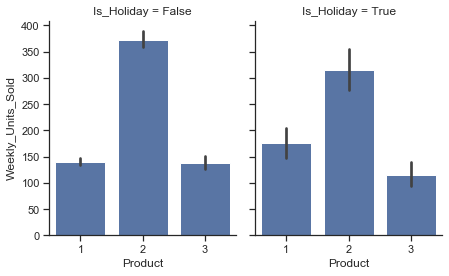

In [42]:
# Plot a 1*2 grid of association between 'Product' and 'Weekly_Units_Sold' under 'Is_Holiday'.
g = sns.FacetGrid(df, col="Is_Holiday", height=4, aspect=.8)
g.map(sns.barplot, "Product", "Weekly_Units_Sold")

- Product 2 is the cheapest product among all the three products, and it sells the most.
- Product 3 is the most expensive product among all the three products.
- In addition, product price did not change during holidays.

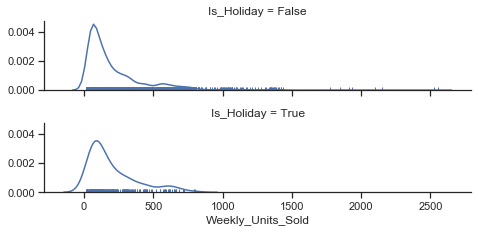

In [43]:
# Plot a 2*1 grid of 'Weekly_Units_Sold' under 'Is_Holiday'.
g = sns.FacetGrid(df, row="Is_Holiday", height=1.7, aspect=4,)
g.map(sns.distplot, "Weekly_Units_Sold", hist=False, rug=True)

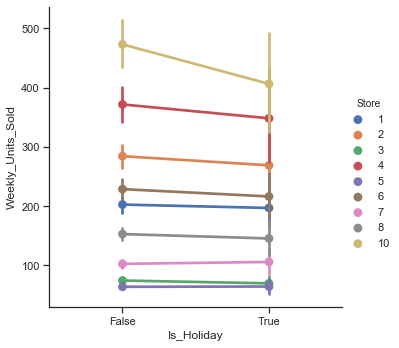

In [44]:
# Draw categorical plots onto a FacetGrid for association between 'Store' and 'Weekly_Units_Sold' under 'Is_Holiday'.
sns.factorplot(data= df, x= 'Is_Holiday', y= 'Weekly_Units_Sold', hue= 'Store')

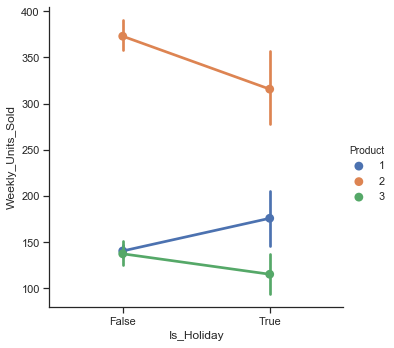

In [45]:
# Draw categorical plots onto a FacetGrid for association between 'Product' and 'Weekly_Units_Sold' under 'Is_Holiday'.
sns.factorplot(data= df, x= 'Is_Holiday', y= 'Weekly_Units_Sold', hue= 'Product')

- It does not seem that holidays have a positive impact for the business. For most of the stores, weekly unit sold during the holiday is as same as the normal days, while store 10 had a decrease during the holidays.
- Weekly units sold for product 1 had a slightly increase during the holidays, while product 2 and product 3 had a decrease during the holidays.

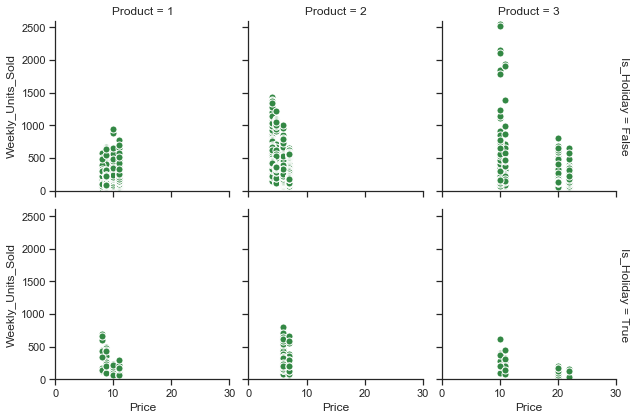

In [46]:
g = sns.FacetGrid(df, col="Product", row="Is_Holiday", margin_titles=True, height=3)
g.map(plt.scatter, "Price", "Weekly_Units_Sold", color="#338844", edgecolor="white", s=50, lw=1)
g.set(xlim=(0, 30), ylim=(0, 2600))

- Every product has more than one prices, both at holidays and normal days. One is regular price, another is promotional price.
- The price gap for product 3 is huge, it was slashed to almost 50% off during promotions.
- Product 3 made the most sales during non-holidays.

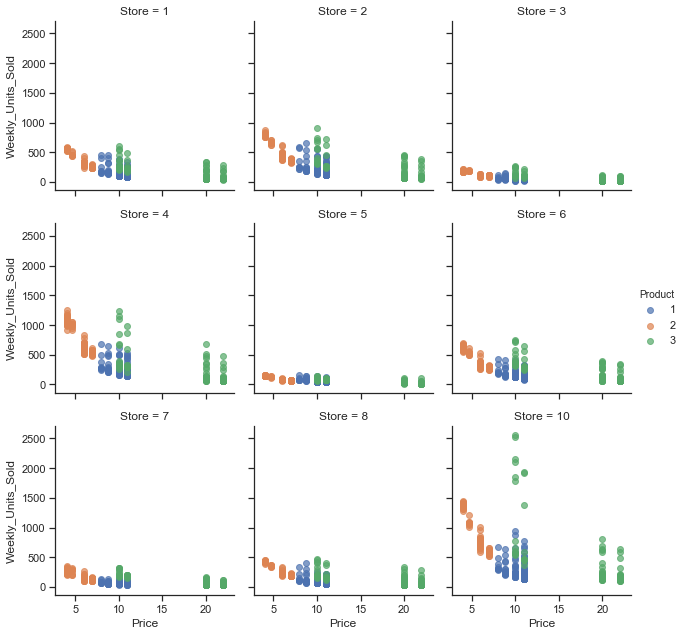

In [47]:
g = sns.FacetGrid(df, col="Store", hue="Product", margin_titles=True, col_wrap=3)
g.map(plt.scatter, 'Price', 'Weekly_Units_Sold', alpha=.7)
g.add_legend()

All of these 9 stores carry these 3 products. They all seem to have similar kind of discount promotions. However, product 3 sells the most units during promotions at store 10.

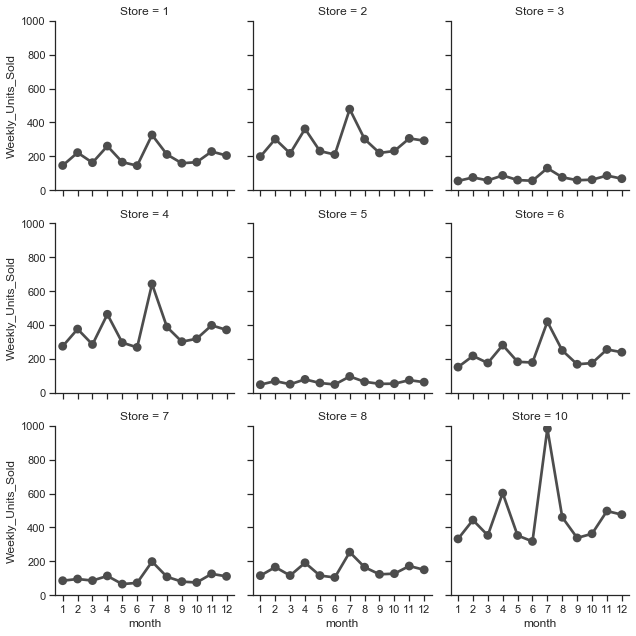

In [48]:
g = sns.FacetGrid(df, col="Store", col_wrap=3, height=3, ylim=(0, 1000))
g.map(sns.pointplot, "month", "Weekly_Units_Sold", color=".3", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12])

Every store has somewhat seasonality, store 10 has the most obvious seasonal pattern.

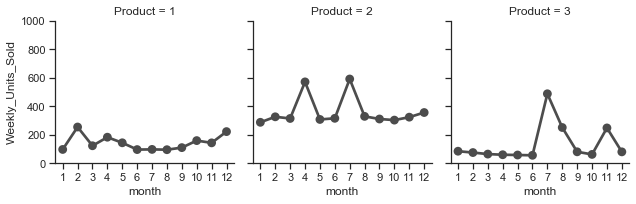

In [49]:
g = sns.FacetGrid(df, col="Product", col_wrap=3, height=3, ylim=(0, 1000))
g.map(sns.pointplot, "month", "Weekly_Units_Sold", color=".3", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12])

Every product has somewhat seasonality, product 2 has two peak seasons per year and product 3 has one.

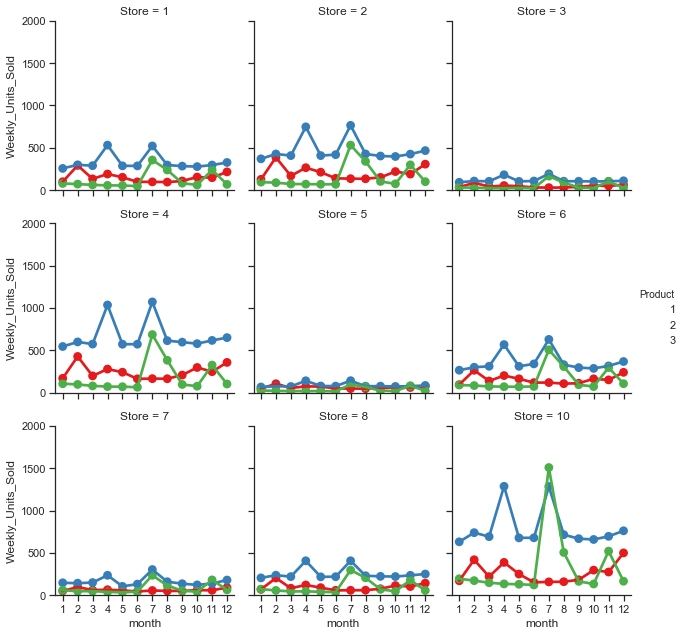

In [50]:
g = sns.FacetGrid(df, col="Store", col_wrap=3, height=3, ylim=(0, 2000), hue='Product', palette="Set1")
g.map(sns.pointplot, "month", "Weekly_Units_Sold", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12], alpha=.7)
g.add_legend()

- In general, product 2 sells more units per week than the other products in every store.
- Once a while, product 3 would exceed product 2 at store 10.

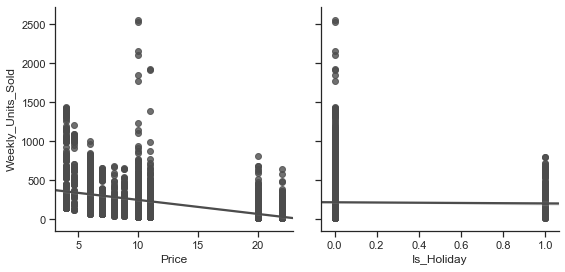

In [52]:
g = sns.PairGrid(df, y_vars=["Weekly_Units_Sold"], x_vars=["Price", "Is_Holiday"], height=4)
g.map(sns.regplot, color=".3")

- The cheaper the price, the more weekly units were sold.
- Is holiday or not has nothing to do with the unit sold.

Adding a new column called “promotion”, which was derived from “Base Price” and “Price”.

In [51]:
def f(row):
    if row['Base Price'] == row['Price']:
        val = 0
    elif row['Base Price'] > row['Price']:
        val = 1
    else:
        val = -1
    return val
df['promotion'] = df.apply(f, axis=1)

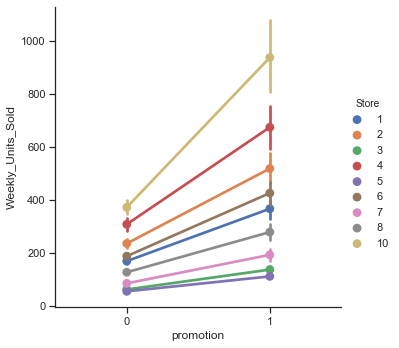

In [53]:
sns.factorplot(data= df, x= 'promotion', y= 'Weekly_Units_Sold', hue= 'Store')

Every store sells more during the promotions, there is no exception.

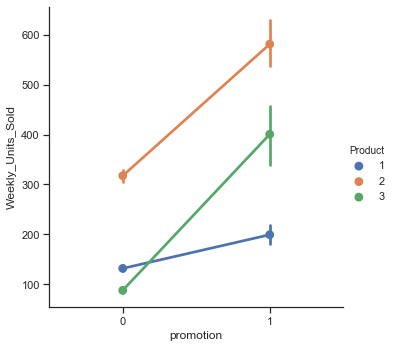

In [54]:
sns.factorplot(data= df, x= 'promotion', y= 'Weekly_Units_Sold', hue= 'Product')

Every product sells more during the promotions, in particular, product 2 and product 3.

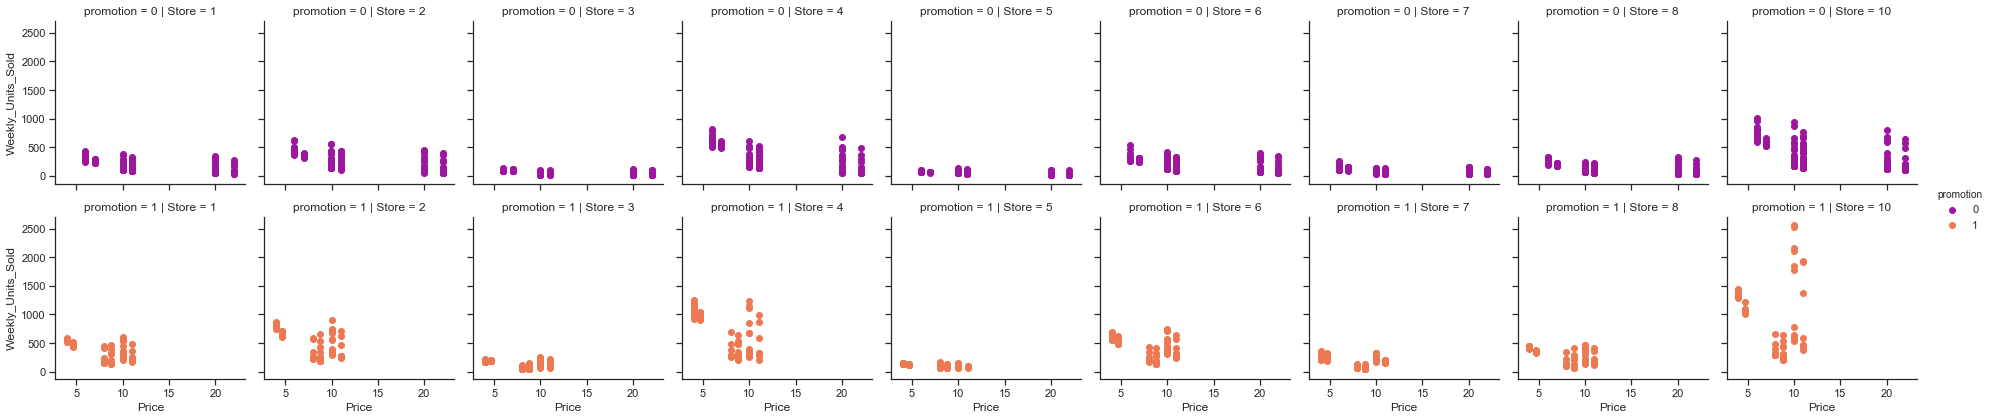

In [55]:
g = sns.FacetGrid(df, col="Store", hue="promotion", palette = 'plasma', row='promotion')
g = (g.map(plt.scatter, "Price", "Weekly_Units_Sold").add_legend())

All the stores have the similar price promotion pattern, for some reason, store 10 sells the most during the promotions.

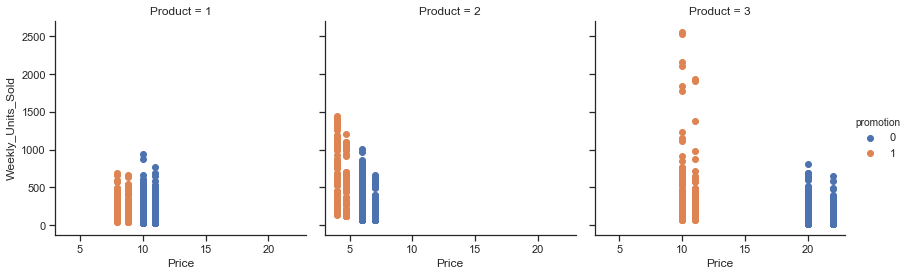

In [57]:
g = sns.FacetGrid(df, hue="promotion", col="Product", height=4)
g.map(plt.scatter, "Price", "Weekly_Units_Sold")
g.add_legend()

Every product has the regular price and promotional price. Product 3 has the highest discount and sells the most during the promotions.

In [58]:
df.groupby(['Product', 'promotion'])['Price', 'Weekly_Units_Sold'].mean()

Price  Weekly_Units_Sold
Product promotion                              
1       0          10.653866         131.637722
        1           8.523333         199.171296
2       0           6.294348         317.388406
        1           4.201429         581.099206
3       0          20.700744          87.748393
        1          10.409091         400.484848

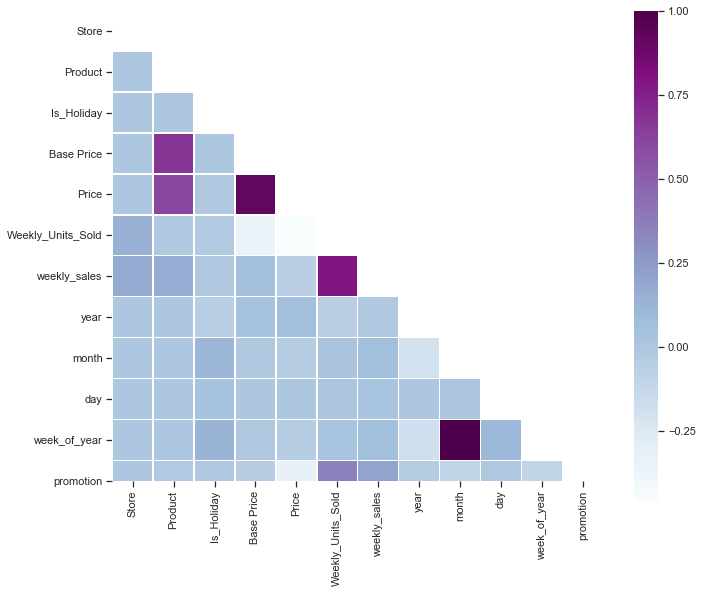

In [61]:
corr_all = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

We have a strong positive correlation between price and Base price, weekly units sold and weekly sales, base price and product, price and product. We can also observe a positive correlation between month and week of the year.

### Observations
- The most selling and crowded Store is Store 10, and the least crowded store is Store 5.
- In terms of number of units sold, the most selling product is product 2 throughout the year.
- Stores do not necessarily run product promotions during holidays. Holidays do not seem to have an impact on stores or products performance.
- Product 2 seems to be the cheapest product, and Product 3 is the most expensive product.
- Most stores have some kind of seasonality and they have two peak seasons per year.
- Product 1 sells a little more in February than the other months, Product 2 sells the most around April and July, and Product 3 sells the most around July to September.
- Each product has its regular price and promotional price. There isn’t significant gap between regular price and promotional price on Product 1 and Product 2, however, Product 3’s promotional price can be slashed to 50% of its original price. Although every store makes this kind of price cut for product 3, store 10 is the one made the highest sales during the price cut.
- It is nothing unusual to sell more during promotion than the normal days. Store 10’s made Product 3 the best selling product around July to September.

## 4. Time Series with Prophet

We are going to build a time series analysis for product 3 at store 10, and we are going to forecast weekly sales in dollars.

In [69]:
# Select 'Base Price', 'Price', 'Weekly_Units_Sold', 'weekly_sales' four features.
store_10_pro_3 = df[(df.Store==10) & (df.Product==3)].loc[:, ['Base Price', 'Price', 'Weekly_Units_Sold', 'weekly_sales']]
store_10_pro_3.reset_index(level=0, inplace=True)
store_10_pro_3.head()

,Date,Base Price,Price,Weekly_Units_Sold,weekly_sales
0,2010-02-05,19.99,19.99,201,4017.99
1,2010-02-12,19.99,19.99,191,3818.09
2,2010-02-19,19.99,19.99,177,3538.23
3,2010-02-26,19.99,19.99,189,3778.11
4,2010-03-05,19.99,19.99,178,3558.22


In [70]:
fig = px.line(store_10_pro_3, x='Date', y='weekly_sales')
fig.update_layout(title_text='Time Series of weekly sales')
fig.show()

Product 2’s seasonality at store 10 is obvious. The sales always peak between July and September during school holiday.

Below we are implementing prophet model, forecasting the weekly sales for the future 50 weeks.

In [81]:
store_10_pro_3 = store_10_pro_3[['Date','weekly_sales']].rename(columns={'Date':'ds', 'weekly_sales':'y'})

KeyError: "None of [Index(['Date', 'weekly_sales'], dtype='object')] are in the [columns]"

In [82]:
model = Prophet(interval_width = 0.95) # Create model
model.fit(store_10_pro_3) # Train model
future_dates = model.make_future_dataframe(periods=50, freq='W') # future 50 weeks

future_dates.tail(7)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
186,2013-08-25
187,2013-09-01
188,2013-09-08
189,2013-09-15
190,2013-09-22
191,2013-09-29
192,2013-10-06


In [83]:
forecast = model.predict(future_dates) # Predicting

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
186,2013-08-25,7160.793666,4837.175346,9498.368774
187,2013-09-01,5542.790168,3358.063488,7905.570833
188,2013-09-08,3702.540515,1232.575013,5977.624884
189,2013-09-15,2427.661638,285.711245,4724.313219
190,2013-09-22,2387.353624,107.674975,4860.101572
191,2013-09-29,3020.829980,652.230070,5297.529441
192,2013-10-06,3158.039106,880.798968,5465.754873


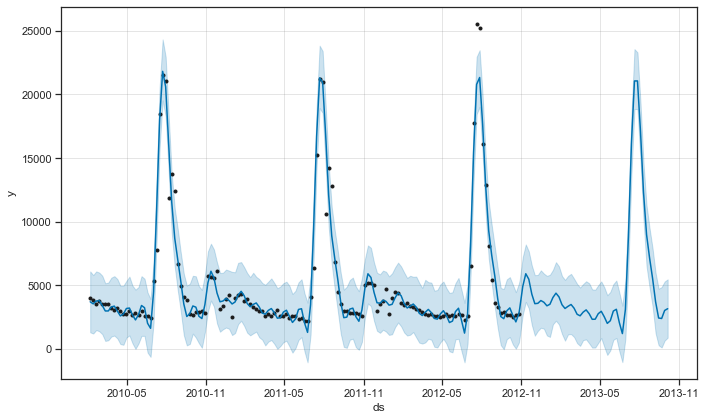

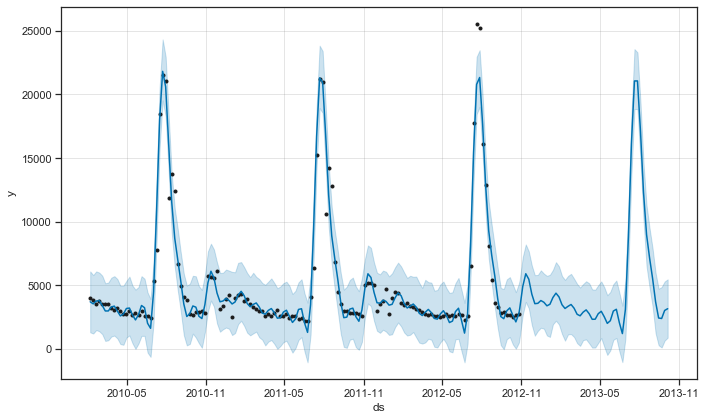

In [84]:
model.plot(forecast)

The model was able to capture the seasonality.

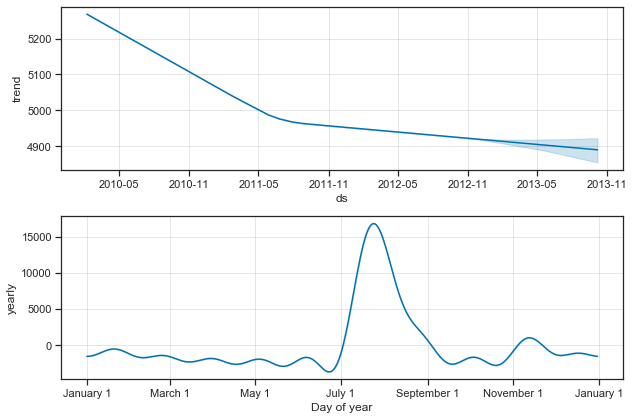

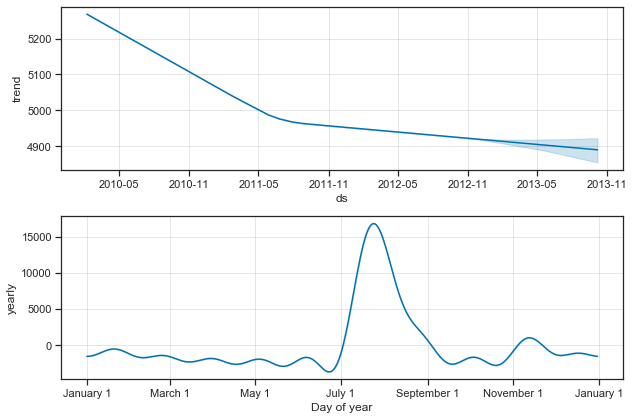

In [73]:
model.plot_components(forecast)

In [74]:
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro_3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))

The RMSE is 1190.0956338021554


## 5. Seasonality effect

A great thing about Prophet is that we can add our own custom seasonalities. Here we are going to add school holiday season that spans from early July to early September.

In [76]:
def is_school_holiday_season(ds):    
    date = pd.to_datetime(ds)
    starts = datetime.date(date.year, 7, 1)
    ends = datetime.date(date.year, 9, 9)
    return starts < date.to_pydatetime().date() < ends

store_10_pro_3['school_holiday_season'] = store_10_pro_3['ds'].apply(is_school_holiday_season)
store_10_pro_3['not_school_holiday_season'] = ~store_10_pro_3['ds'].apply(is_school_holiday_season)

In [77]:
model = Prophet(interval_width=0.95)

model.add_seasonality(name='school_holiday_season', 
                      period=365, 
                      fourier_order=3, 
                      condition_name='school_holiday_season')
model.add_seasonality(name='not_school_holiday_season', 
                      period=365, 
                      fourier_order=3, 
                      condition_name='not_school_holiday_season')

model.fit(store_10_pro_3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'Weekly sales forecast')

<Figure size 720x360 with 0 Axes>

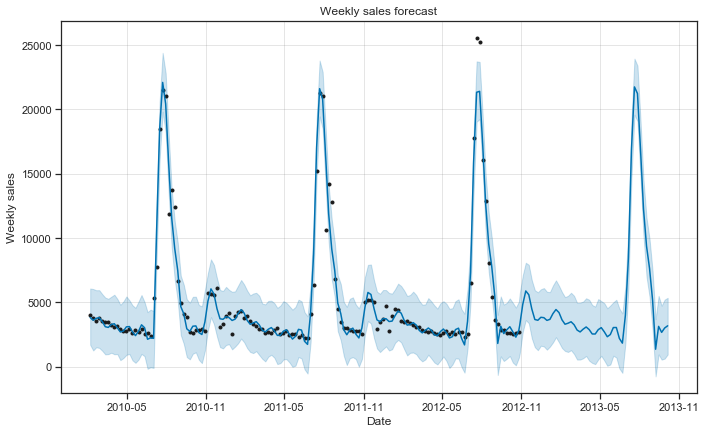

In [78]:
forecast = model.make_future_dataframe(periods=50, freq='W')
forecast['school_holiday_season'] = forecast['ds'].apply(is_school_holiday_season)
forecast['not_school_holiday_season'] = ~forecast['ds'].apply(is_school_holiday_season)
forecast = model.predict(forecast)

plt.figure(figsize=(10, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'Weekly sales')
plt.title('Weekly sales forecast')

In [79]:
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro_3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))

The RMSE is 1127.1252945470821


The RMSE decreased a little.

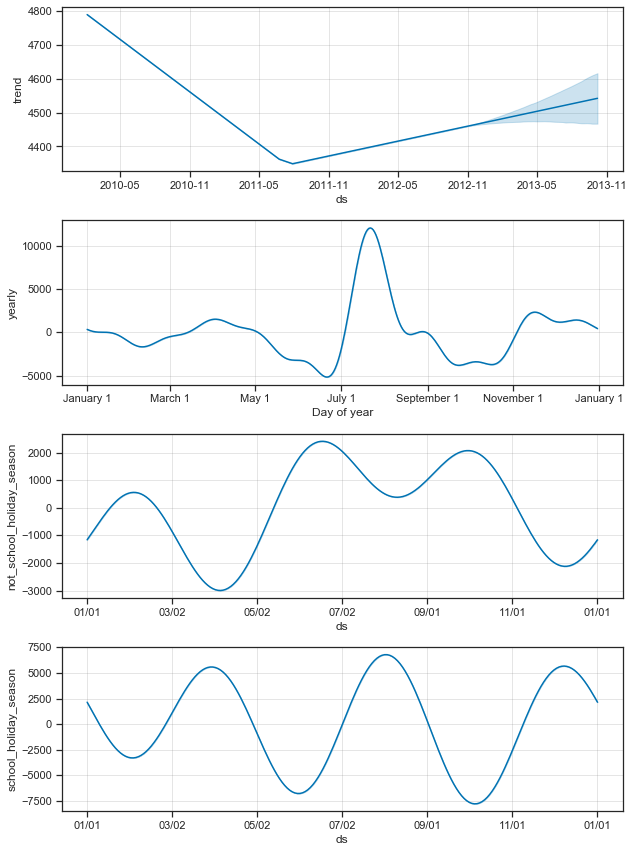

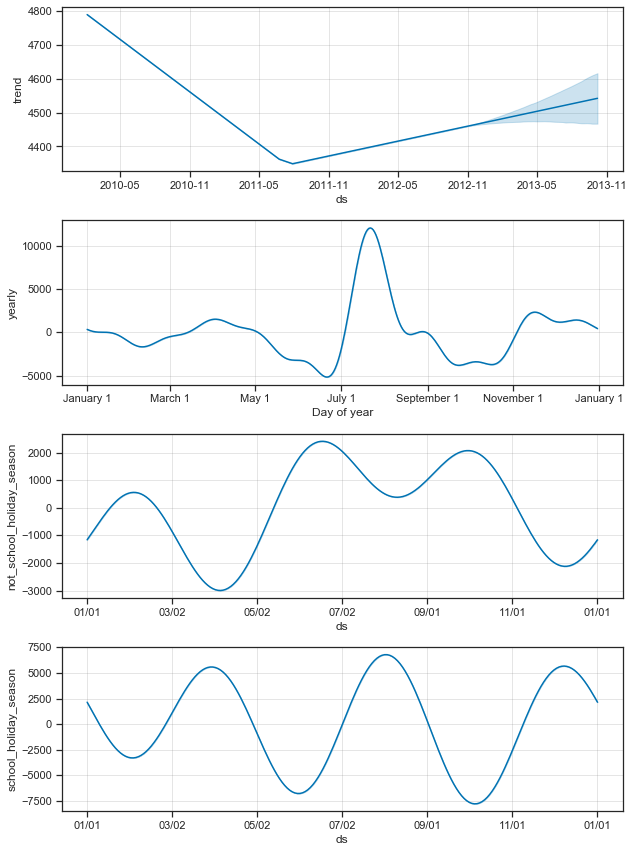

In [80]:
model.plot_components(forecast)